In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List
import json

# remove punctuations and use lowercase
def tokenize(sentence: str) -> List[str]:
    def trim_all(token: str) -> str:
        if len(token) == 0:
            return token
        while len(token) > 0 and (token[0] == '"' or token[0] == '('):
            token = token[1:]
        while len(token) > 0 and (token[-1] == '"' or token[-1] == '.' or 
            token[-1] == ',' or token[-1] == ')' or token[-1] == '!' or token[-1] == '?'):
            token = token[:-1]
        return token

    words = sentence.split(' ')
    tokens = []
    for word in words:
        if len(word) == 0 or word.isspace():
            continue
        lowercase = word.lower()
        trimmed = trim_all(lowercase)
        tokens.append(trimmed)
    return tokens

def compute_accuracy(reference: str, translation: str) -> float:
    # precision = correct / output-length
    # recall = correct / reference-length
    # f = p * q * 2 / (p + q)
    correct = list((Counter(reference) & Counter(translation)).elements())
    overlap = len(correct)
    # return if denom is 0
    if overlap == 0:
        return 0, 0, 0
    precision = overlap / len(translation)
    recall = overlap / len(reference)
    f = precision * recall * 2 / (precision + recall)
    return round(f, 3), precision, recall

In [2]:
with open('../data/daide_to_english.json', 'r', encoding='utf-8') as f:
    lines = json.load(f)

daide_arr = []
ref_arr = []
trnsln_arr = []
f_arr = []
len_arr = []

count = 0
avg_precision = 0
avg_recall = 0

for entry in lines:
    eng = entry['msg']
    daide = entry['daide']
    translation = entry['translation']

    if len(translation) == 0:
        continue
    eng_tok = tokenize(eng)
    translation_tok = tokenize(translation[13:])

    if len(translation) > 0 and not translation.isspace() and len(translation_tok) > 0:
        count += 1
        trnsln_arr.append(translation[13:])
        ref_arr.append(eng[9:])
        daide_arr.append(daide)
        accuracy, precision, recall = compute_accuracy(eng_tok, translation_tok)
        avg_precision += precision
        avg_recall += recall
        f_arr.append(accuracy)
        len_arr.append(len(tokenize(daide)))

print('Average precision: ', round(avg_precision / count, 3))
print('Average recall: ', round(avg_recall / count, 3))

Average precision:  0.28
Average recall:  0.149


In [3]:
d = {'English': ref_arr, 'Translation': trnsln_arr, 'DAIDE': daide_arr, 'DAIDE_length': len_arr, 'F-Score': f_arr}
df = pd.DataFrame(data=d)
df

,English,Translation,DAIDE,DAIDE_length,F-Score
0,hope you're doing well. I'll be figuring out ...,"aly are demilitarizing Piedmont, Lyon, Weser a...",PRP (DMZ (FRA ITA) (PIE LYO WES TYS)),8,0.048
1,"trong England is always a threat to me, so I'd...",o cooperate with Germany against England.,YES (PRP (ALY (GER FRA) VSS (ENG))),7,0.071
2,What direction are you inclined to go? Are you...,a demilitarized zone between Austria and Russ...,PRP (DMZ (AUS RUS) (GAL)),5,0.080
3,fast and break things? I’m fleets you’re armi...,an alliance between Turkey and Austria agains...,PRP (ALY (TUR AUS) VSS (RUS ITA)),7,0.162
4,"rk to split Italy between the two of us, right...",o give Austria Trieste and Turkey Naples and T...,PRP (SCD (AUS TRI ROM) (TUR NAP TUN)),8,0.074
...,...,...,...,...,...
307,he Italian army from Greece to Albania.,Italian army from Greece to Albania.,PRP (XDO ((ITA AMY GRE) RTO ALB)),7,0.857
308,rench fleet in the English Channel support the...,porting its army in Belgium with its fleet in ...,PRP (XDO ((FRA FLT ECH) SUP (FRA AMY BEL))),9,0.417
309,y! Are you up for Sil as a DMZ? It would be in...,a demilitarized zone between Russia and Germa...,PRP (DMZ (RUS GER) (SIL)),5,0.097
310,! I fully agree that we should stay peaceful w...,o accept an alliance between Austria and Turkey.,YES (PRP (PCE (AUS TUR))),5,0.103


In [4]:
df.sort_values(by=['F-Score'], ascending=False).head()

,English,Translation,DAIDE,DAIDE_length,F-Score
301,"e an alliance between Germany, Austria and Ita...","an alliance between Germany, Austria, and Ita...",PRP (ALY (GER AUS ITA) VSS (FRA RUS)),8,0.917
307,he Italian army from Greece to Albania.,Italian army from Greece to Albania.,PRP (XDO ((ITA AMY GRE) RTO ALB)),7,0.857
300,Austria and Italy are allies against France an...,"an alliance between Germany, Austria, and Ita...",PRP (ALY (GER AUS ITA) VSS (FRA RUS)),8,0.762
83,"g Edi into NTH, and NTH into helgo","i into NTH, and NTH into Helgo.",PRP (AND (XDO ((ENG FLT EDI) MTO NTH)) (XDO ((...,14,0.750
305,"e peace between England, France and Germany.","alliance between England, France, and Germany.",PRP (PCE (ENG FRA GER)),5,0.714


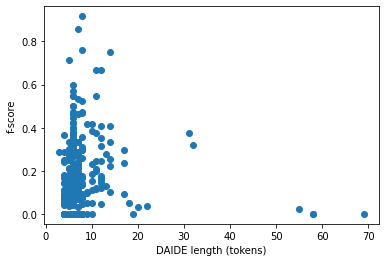

In [5]:
x = np.array(df['DAIDE_length'])
y = np.array(df['F-Score'])

plt.scatter(x, y)
plt.xlabel("DAIDE length (tokens)")
plt.ylabel("f-score")
plt.show()

In [6]:
rslt_df = df[df['F-Score'] < 0.01]
rslt_df.shape
print(f"Percentage of translations with f-score = 0: {round(rslt_df.shape[0]/ count * 100, 2)}%")

Percentage of translations with f-score = 0: 16.03%


In [7]:
np.average(df['F-Score'])

0.17473717948717948